[*********************100%%**********************]  1 of 1 completed

Processing DIS...


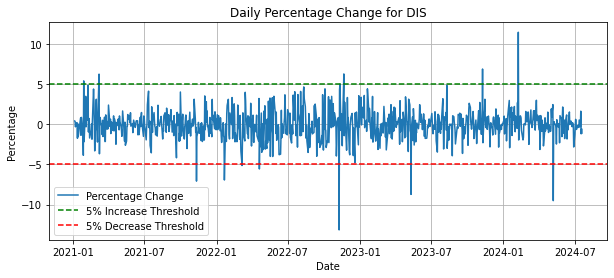

Saved significant changes for DIS to significant_changes_DIS.csv
Training Random Forest model for DIS...
Training LSTM model for DIS...


[*********************100%%**********************]  1 of 1 completed

Processing AAPL...


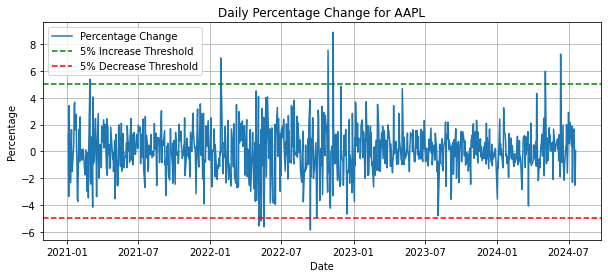

Saved significant changes for AAPL to significant_changes_AAPL.csv
Training Random Forest model for AAPL...
Training LSTM model for AAPL...


[*********************100%%**********************]  1 of 1 completed

Processing COIN...


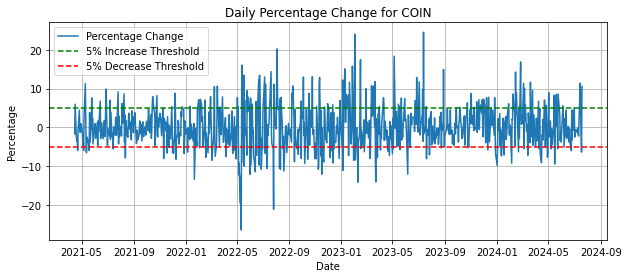

Saved significant changes for COIN to significant_changes_COIN.csv
Training Random Forest model for COIN...
Training LSTM model for COIN...


[*********************100%%**********************]  1 of 1 completed

Processing NVDA...


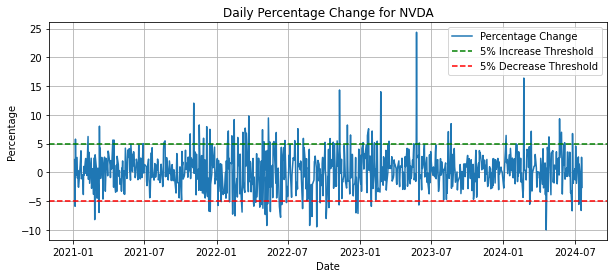

Saved significant changes for NVDA to significant_changes_NVDA.csv
Training Random Forest model for NVDA...
Training LSTM model for NVDA...


[*********************100%%**********************]  1 of 1 completed

Processing AMD...


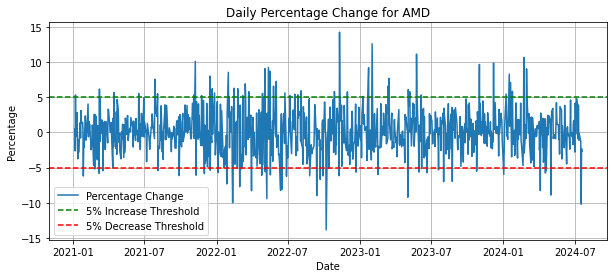

Saved significant changes for AMD to significant_changes_AMD.csv
Training Random Forest model for AMD...
Training LSTM model for AMD...


[*********************100%%**********************]  1 of 1 completed

Processing TSLA...


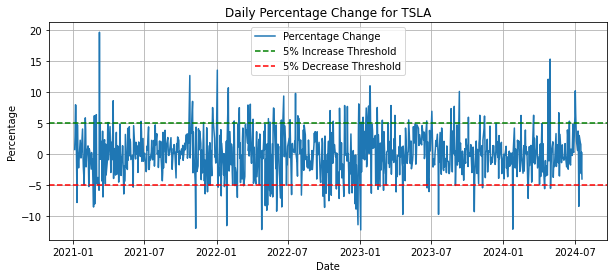

Saved significant changes for TSLA to significant_changes_TSLA.csv
Training Random Forest model for TSLA...
Training LSTM model for TSLA...


[*********************100%%**********************]  1 of 1 completed

Processing AMZN...


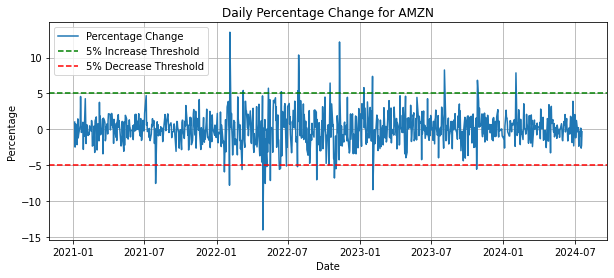

Saved significant changes for AMZN to significant_changes_AMZN.csv
Training Random Forest model for AMZN...
Training LSTM model for AMZN...


[*********************100%%**********************]  1 of 1 completed

Processing META...


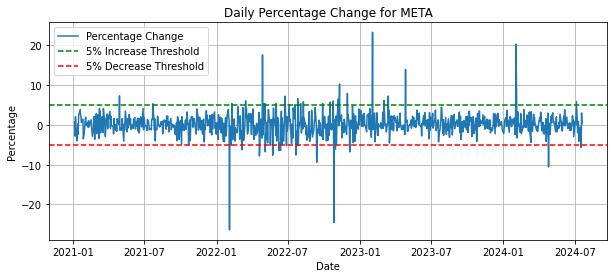

Saved significant changes for META to significant_changes_META.csv
Training Random Forest model for META...
Training LSTM model for META...


[*********************100%%**********************]  1 of 1 completed

Processing NFLX...


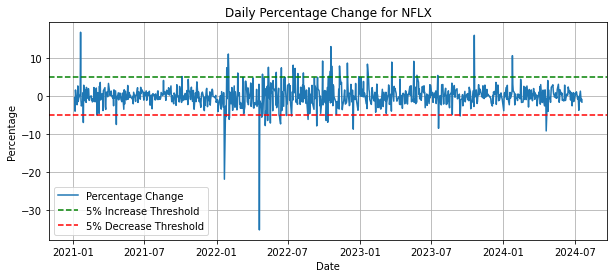

Saved significant changes for NFLX to significant_changes_NFLX.csv
Training Random Forest model for NFLX...
Training LSTM model for NFLX...


[*********************100%%**********************]  1 of 1 completed

Processing GOOGL...


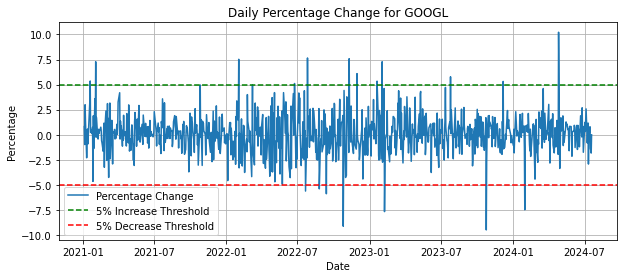

Saved significant changes for GOOGL to significant_changes_GOOGL.csv
Training Random Forest model for GOOGL...
Training LSTM model for GOOGL...


[*********************100%%**********************]  1 of 1 completed

Processing SMCI...


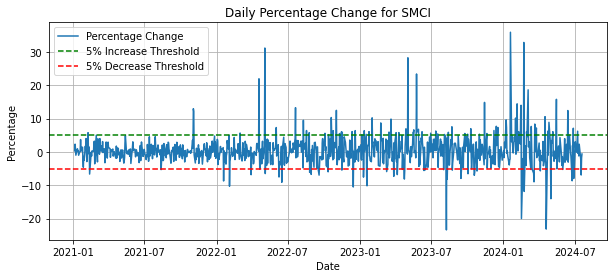

Saved significant changes for SMCI to significant_changes_SMCI.csv
Training Random Forest model for SMCI...
Training LSTM model for SMCI...
Pivot table saved to 'predicted_significant_moves_pivot_filled.csv'
LSTM predictions saved to 'lstm_predictions_pivot_filled.csv'


In [8]:
# Import necessary packages
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from datetime import datetime, timedelta
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
import os
from imblearn.over_sampling import SMOTE

# Disable TensorFlow debugging information
tf.get_logger().setLevel('ERROR')

# List of tickers
tickers = ['DIS', 'AAPL', 'COIN', 'NVDA', 'AMD', 'TSLA', 'AMZN', 'META', 'NFLX', 'GOOGL', 'SMCI']

# Get the trading calendar for the next 60 trading days
nyse = mcal.get_calendar('NYSE')

# Initialize an empty DataFrame to store predictions
all_predictions = pd.DataFrame()

# Initialize an empty DataFrame to store LSTM predictions
lstm_predictions = pd.DataFrame()

# Variables to track the best model and its performance
best_f1_score = 0
best_model = None
best_ticker = None

# Loop over each ticker
for ticker in tickers:
    print(f"Processing {ticker}...")

    # Download stock data
    stock_data = yf.download(ticker, start='2021-01-01', end=datetime.now().strftime('%Y-%m-%d'))

    # Calculate daily percentage change
    stock_data['Pct_Change'] = stock_data['Adj Close'].pct_change() * 100

    # Log significant daily percentage changes
    significant_changes = stock_data[stock_data['Pct_Change'].abs() > 5]
    if not significant_changes.empty:
        # Plot the percentage change
        plt.figure(figsize=(10, 4))
        plt.plot(stock_data['Pct_Change'], label='Percentage Change')
        plt.title(f'Daily Percentage Change for {ticker}')
        plt.axhline(y=5, color='g', linestyle='--', label='5% Increase Threshold')
        plt.axhline(y=-5, color='r', linestyle='--', label='5% Decrease Threshold')
        plt.legend()
        plt.ylabel('Percentage')
        plt.xlabel('Date')
        plt.grid(True)
        plt.show()
    
        # Save significant changes to a CSV file
        filename = f'significant_changes_{ticker}.csv'
        significant_changes.to_csv(filename)
        print(f"Saved significant changes for {ticker} to {filename}")
    else:
        print(f"No significant changes greater than 5% for {ticker}")

    # Create a new column for significant moves
    stock_data['Significant_Move'] = stock_data['Pct_Change'].abs() > 5

    # Shift the 'Significant_Move' column to create lag features
    for i in range(1, 6):
        stock_data[f'Significant_Move_Lag_{i}'] = stock_data['Significant_Move'].shift(i)

    # Drop rows with NaN values
    stock_data.dropna(inplace=True)

    # Define the features (X) and target (y)
    X = stock_data[[f'Significant_Move_Lag_{i}' for i in range(1, 6)]]
    y = stock_data['Significant_Move']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Train a Random Forest Classifier
    print(f"Training Random Forest model for {ticker}...")
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_smote, y_train_smote)

    # Make predictions on the test set to evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)


    # Track the best model based on F1 score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model
        best_ticker = ticker

    # Generate future dates for prediction
    last_date = stock_data.index[-1]
    future_dates = nyse.schedule(start_date=last_date + timedelta(days=1), end_date=last_date + timedelta(days=80)).index

    # Initialize future data with the trading dates
    future_data = pd.DataFrame(index=future_dates)

    # Get the last known values for the lagged features
    last_known_values = stock_data.iloc[-1][[f'Significant_Move_Lag_{i}' for i in range(1, 6)]].values

    # Initialize the future data with the last known values
    for i in range(1, 6):
        future_data[f'Significant_Move_Lag_{i}'] = last_known_values[i-1]

    # Update the lag features for future dates
    for i in range(1, len(future_data)):
        for j in range(1, 6):
            if i >= j:
                future_data.loc[future_data.index[i], f'Significant_Move_Lag_{j}'] = future_data.iloc[i-j][f'Significant_Move_Lag_{1}']
            else:
                future_data.loc[future_data.index[i], f'Significant_Move_Lag_{j}'] = last_known_values[-j+i]

    # Drop any rows with NaN values (which shouldn't exist, but just in case)
    future_data.dropna(inplace=True)

    # Make predictions for future dates
    future_predictions = model.predict(future_data)
    predicted_moves = pd.DataFrame({
        'Ticker': ticker,
        'Date': future_dates[:len(future_predictions)],
        'Predicted_Significant_Move': future_predictions
    })

    # Append to the all_predictions DataFrame
    all_predictions = pd.concat([all_predictions, predicted_moves], ignore_index=True)

    # LSTM for stock price prediction
    print(f"Training LSTM model for {ticker}...")
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))

    def create_dataset(data, time_step=1):
        X, Y = [], []
        for i in range(len(data)-time_step-1):
            a = data[i:(i+time_step), 0]
            X.append(a)
            Y.append(data[i + time_step, 0])
        return np.array(X), np.array(Y)

    time_step = 100
    X, y = create_dataset(scaled_data, time_step)

    # Splitting dataset into train and test split
    training_size = int(len(X)*0.67)
    test_size = len(X)-training_size
    X_train, X_test = X[0:training_size], X[training_size:len(X)]
    y_train, y_test = y[0:training_size], y[training_size:len(y)]

    # Reshape input to be [samples, time steps, features] required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Build the LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
    lstm_model.add(LSTM(50, return_sequences=True))
    lstm_model.add(LSTM(50))
    lstm_model.add(Dense(1))

    lstm_model.compile(loss='mean_squared_error', optimizer='adam')

    # Training without verbose output
    lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=0)

    # Prediction
    train_predict = lstm_model.predict(X_train, verbose=0)
    test_predict = lstm_model.predict(X_test, verbose=0)

    # Transform back to original form
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # Predict the next 10 days
    last_time_step_data = scaled_data[-time_step:]
    predictions = []
    for _ in range(10):
        input_data = last_time_step_data.reshape((1, time_step, 1))
        pred = lstm_model.predict(input_data, verbose=0)
        predictions.append(pred[0, 0])
        last_time_step_data = np.append(last_time_step_data[1:], pred)

    # Transform predictions back to original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Create future dates for the predictions
    future_dates_lstm = pd.date_range(start=stock_data.index[-1], periods=len(predictions) + 1, inclusive='right')
    # Ensure lengths of future_dates_lstm and predictions are the same
    if len(future_dates_lstm) > len(predictions):
        future_dates_lstm = future_dates_lstm[:len(predictions)]
    elif len(predictions) > len(future_dates_lstm):
        predictions = predictions[:len(future_dates_lstm)]

    # Save the predictions to lstm_predictions DataFrame
    lstm_predictions_ticker = pd.DataFrame({
        'Date': future_dates_lstm,
        'Ticker': ticker,
        'Predicted_Close_Price': predictions.flatten()
    })
    lstm_predictions = pd.concat([lstm_predictions, lstm_predictions_ticker], ignore_index=True)

# Use the best model for further predictions
if best_model:
    future_predictions = best_model.predict(future_data)
    # Proceed with further steps for using these predictions

# Save Random Forest predictions
pivot_table = all_predictions.pivot(index='Date', columns='Ticker', values='Predicted_Significant_Move')
pivot_table.fillna(False, inplace=True)
pivot_table.to_csv('predicted_significant_moves_pivot_filled.csv', index=True, mode='w')
print("Pivot table saved to 'predicted_significant_moves_pivot_filled.csv'")

# Save LSTM predictions
lstm_predictions_pivot = lstm_predictions.pivot(index='Date', columns='Ticker', values='Predicted_Close_Price')
lstm_predictions_pivot.to_csv('lstm_predictions_pivot_filled.csv', index=True, mode='w')
print("LSTM predictions saved to 'lstm_predictions_pivot_filled.csv'")


[*********************100%%**********************]  1 of 1 completed


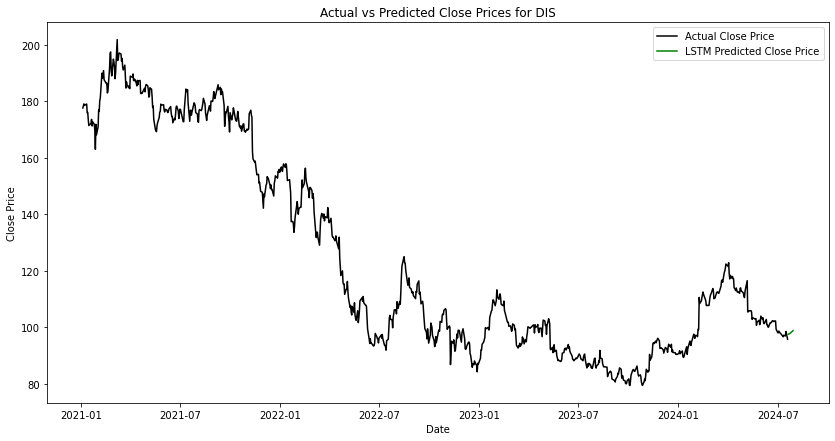

[*********************100%%**********************]  1 of 1 completed


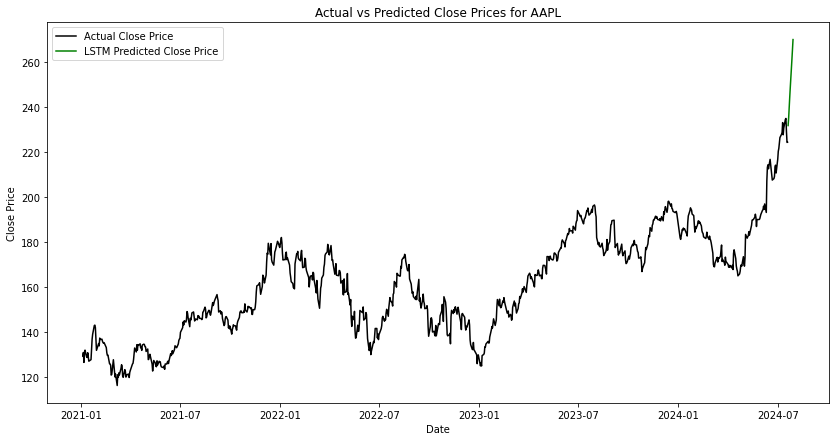

[*********************100%%**********************]  1 of 1 completed


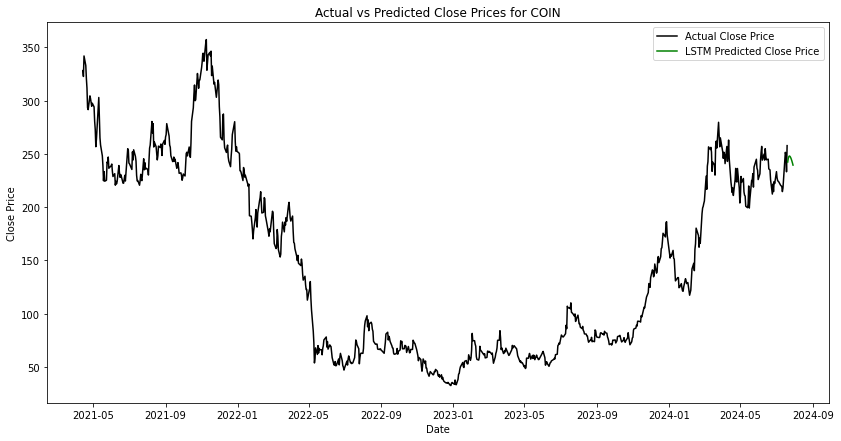

[*********************100%%**********************]  1 of 1 completed


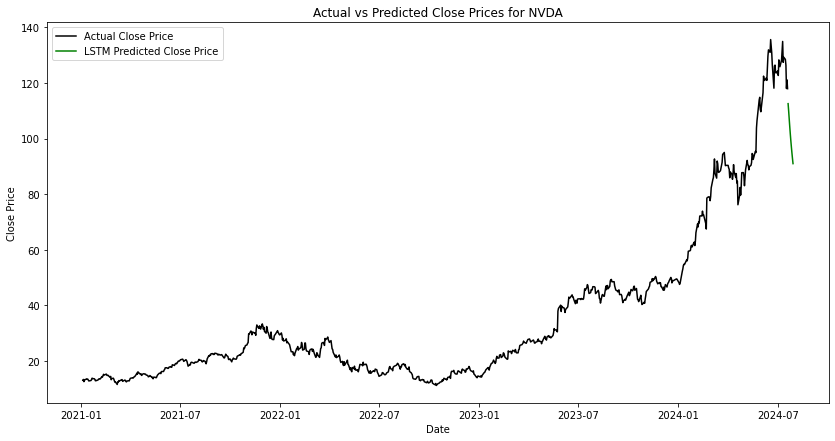

[*********************100%%**********************]  1 of 1 completed


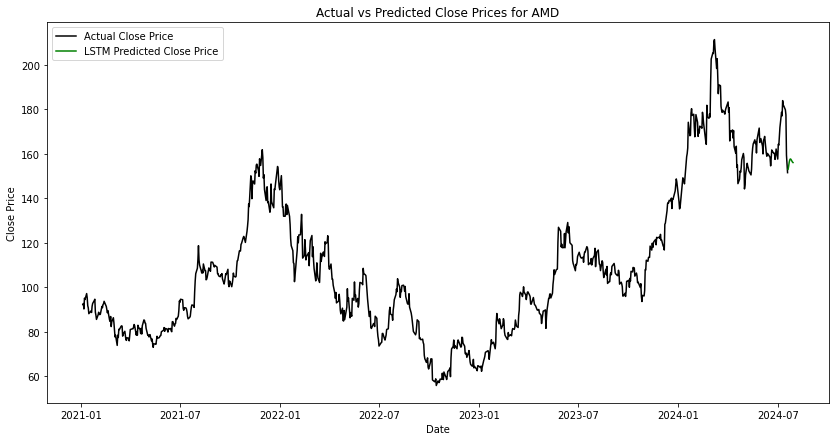

[*********************100%%**********************]  1 of 1 completed


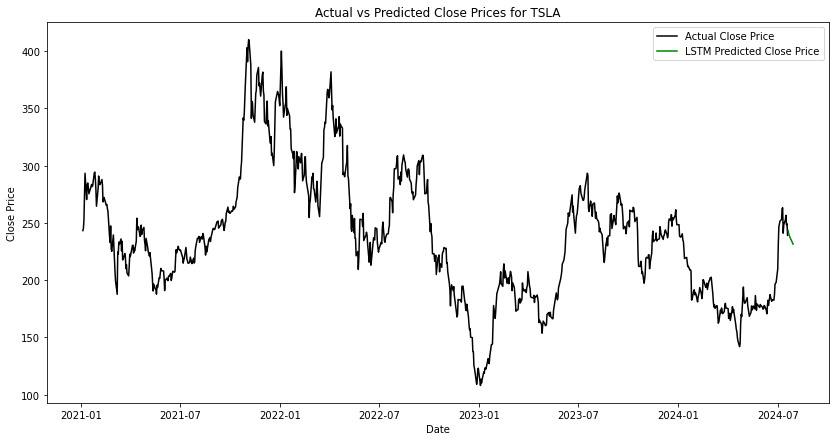

[*********************100%%**********************]  1 of 1 completed


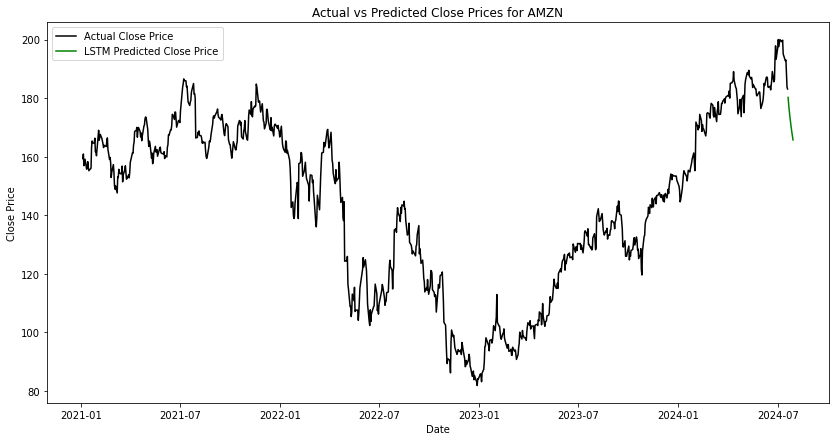

[*********************100%%**********************]  1 of 1 completed


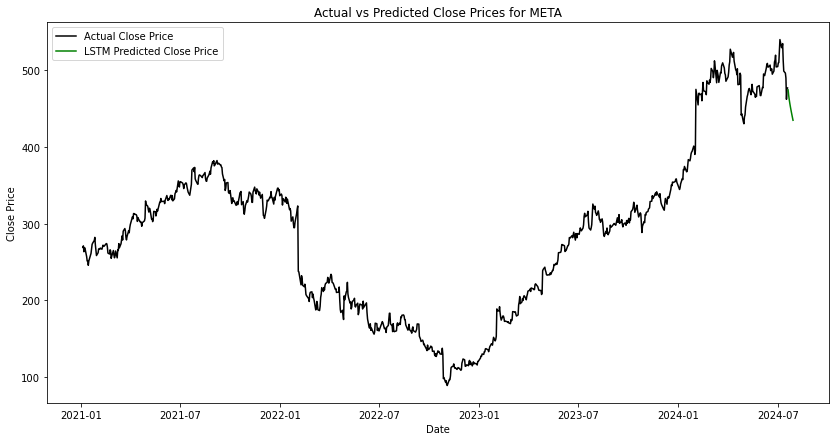

[*********************100%%**********************]  1 of 1 completed


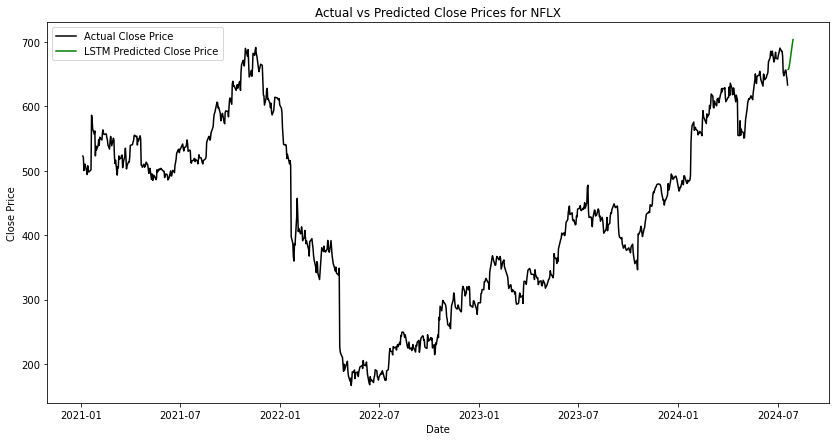

[*********************100%%**********************]  1 of 1 completed


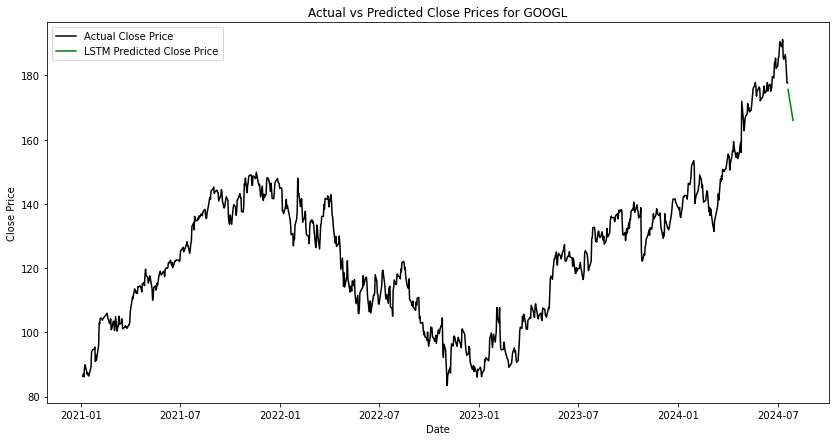

[*********************100%%**********************]  1 of 1 completed


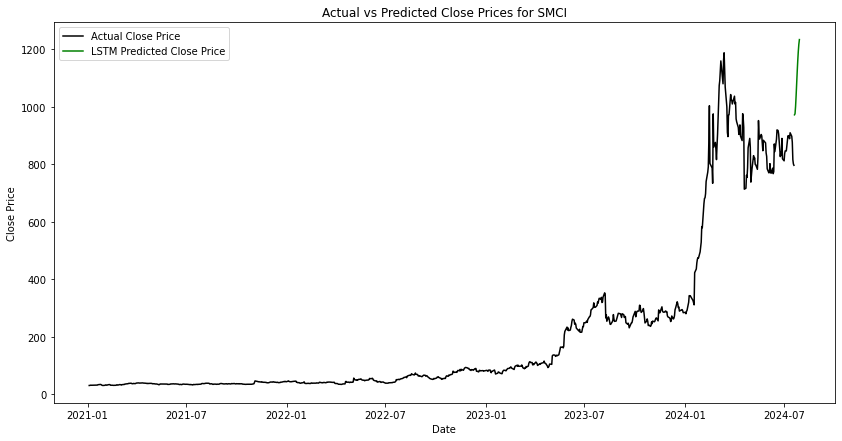

In [9]:
# Visualization

# Random Forest Predictions
rf_predictions = pd.read_csv('predicted_significant_moves_pivot_filled.csv', index_col='Date', parse_dates=True)

# LSTM Predictions
lstm_predictions = pd.read_csv('lstm_predictions_pivot_filled.csv', index_col='Date', parse_dates=True)

# Create a directory to save the plots
plot_directory = 'stock_plots'
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)
    
# Combining Actual and Predicted Prices for LSTM
for ticker in tickers:
    # Download stock data
    stock_data = yf.download(ticker, start='2021-01-01', end=datetime.now().strftime('%Y-%m-%d'))

    plt.figure(figsize=(14, 7))

    # Ensure that index and 'Close' data are in the correct format.
    index_array = np.array(stock_data.index)
    close_array = np.array(stock_data['Close'])

    # Plot actual closing prices
    plt.plot(index_array, close_array, label='Actual Close Price', color='black')

    # Ensure the predictions are also converted to numpy arrays for consistent plotting
    prediction_index_array = np.array(lstm_predictions.index)
    prediction_close_array = np.array(lstm_predictions[ticker])

    # Plot LSTM predicted closing prices
    plt.plot(prediction_index_array, prediction_close_array, label='LSTM Predicted Close Price', color='green')

    plt.title(f'Actual vs Predicted Close Prices for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()

    # Save the plot
    plot_path = os.path.join(plot_directory, f'{ticker}_actual_vs_predicted.png')
    plt.savefig(plot_path)
    
    # Show the plot
    plt.show()